In [33]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Alameda County Jury Panels ##

In [34]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


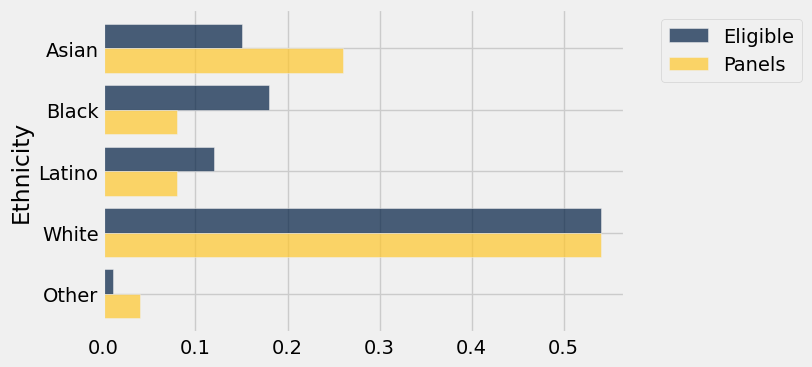

In [35]:
jury.barh('Ethnicity')

In [37]:
# Under the model, this is the true distribution of people
# from which the jurors are randomly sampled
model = jury.column('Eligible')
model

array([ 0.15,  0.18,  0.12,  0.54,  0.01])

In [41]:
# Let's simulate a random draw of 1423 jurors from this distribution
simulated = sample_proportions(1423, model)
simulated

array([ 0.15671117,  0.19606465,  0.11243851,  0.52635278,  0.00843289])

In [42]:
# The actual observed distribution (Panels) looks quite different
# from the simulation -- try running this several times to confirm!
jury_with_simulated = jury.with_column('Simulated', simulated)
jury_with_simulated

Ethnicity,Eligible,Panels,Simulated
Asian,0.15,0.26,0.156711
Black,0.18,0.08,0.196065
Latino,0.12,0.08,0.112439
White,0.54,0.54,0.526353
Other,0.01,0.04,0.00843289


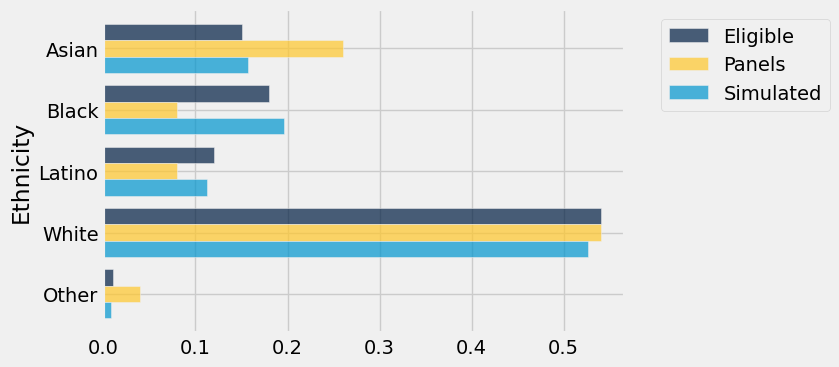

In [43]:
jury_with_simulated.barh('Ethnicity')

## Distance Between Distributions

In [25]:
#  In the Mendel model from before, the difference between observed white/purple
# and their expected values (26%/75%) was our statistic.
#
# In this case, we need to understand how each of the 5 categories
# differ from their expected values according to the model.

diffs = jury.column('Panels') - jury.column('Eligible')
jury_with_difference = jury.with_column('Difference', diffs)
jury_with_difference

Ethnicity,Eligible,Panels,Difference
Asian,0.15,0.26,0.11
Black,0.18,0.08,-0.1
Latino,0.12,0.08,-0.04
White,0.54,0.54,0
Other,0.01,0.04,0.03


## Total Variation Distance

In [26]:
def tvd(dist1, dist2):
    return sum(abs(dist1 - dist2))/2

In [45]:
# The TVD of our observed data (Panels) from their expected values
# assuming the model is true (Eligbible)
obsvd_tvd = tvd(jury.column('Panels'), jury.column('Eligible'))
obsvd_tvd

0.14000000000000001

In [46]:
# The TVD of a model simluation from its expected values
tvd(sample_proportions(1423, model), model)

0.015586788475052755

In [48]:
def simulated_tvd():
    return tvd(sample_proportions(1423, model), model)

tvds = make_array()

num_simulations = 10000
for i in np.arange(num_simulations):
    new_tvd = simulated_tvd()
    tvds = np.append(tvds, new_tvd)

Observed TVD: 0.14


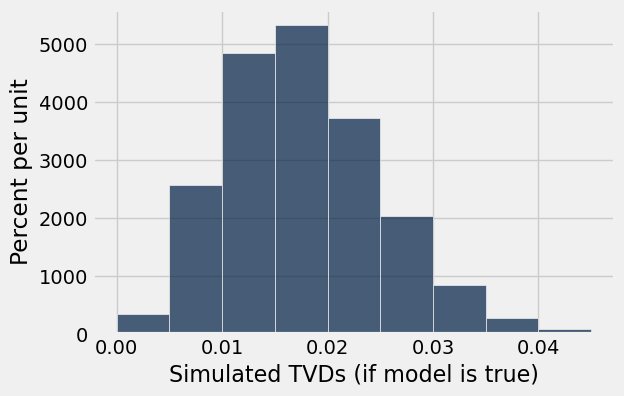

In [49]:
title = 'Simulated TVDs (if model is true)'
bins = np.arange(0, .05, .005)

Table().with_column(title, tvds).hist(bins = bins)
print('Observed TVD: ' + str(obsvd_tvd))

## The Instructor's Defense ##

In [50]:
scores = Table.read_table('scores_by_section.csv')
scores

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


In [51]:
scores.group('Section')

Section,count
1,32
2,32
3,27
4,30
5,33
6,32
7,24
8,29
9,30
10,34


In [4]:
scores.group('Section', np.average).show()

Section,Midterm average
1,15.5938
2,15.125
3,13.6667
4,14.7667
5,17.4545
6,15.0312
7,16.625
8,16.3103
9,14.5667
10,15.2353


In [52]:
observed_average = 13.6667 

In [53]:
random_sample = scores.sample(27, with_replacement=False)
random_sample

Section,Midterm
9,0
9,16
2,17
6,21
10,7
11,22
6,18
2,24
1,20
4,19


In [57]:
np.average(random_sample.column('Midterm'))

15.296296296296296

In [95]:
# Simulate one value of the test statistic 
# under the hypothesis that the section is like a random sample from the class
def random_sample_midterm_avg():
    random_sample = scores.sample(27, with_replacement = False)
    return np.average(random_sample.column('Midterm'))

In [96]:
# Simulate 50,000 copies of the test statistic

sample_averages = make_array()

for i in np.arange(50000):
    sample_averages = np.append(sample_averages, random_sample_midterm_avg())    

## Our Decision

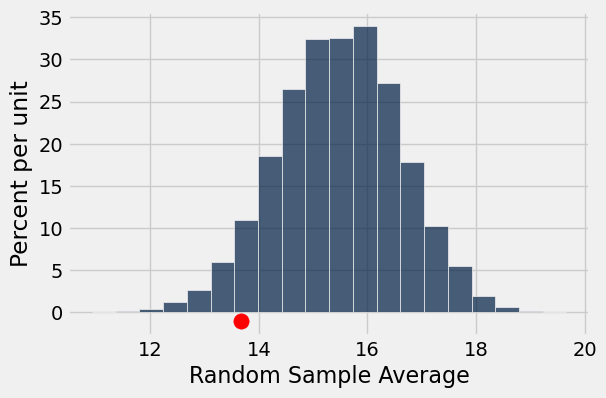

In [97]:
# Compare the simulated distribution of the statistic
# and the actual observed statistic
averages_tbl = Table().with_column('Random Sample Average', sample_averages)
averages_tbl.hist(bins = 20)
plots.scatter(observed_average, -0.01, color='red', s=120);

### Approach 1

In [98]:
# (1) Calculate the p-value: simulation area beyond observed value
np.count_nonzero(sample_averages <= observed_average) / 50000
# (2) See if this is less than 5%

0.0575

### Approach 2

In [99]:
# (1) Find simulated value corresponding to 5% of 50,000 = 2500
five_percent_point = averages_tbl.sort(0).column(0).item(2500)
five_percent_point

13.592592592592593

In [100]:
# (2) See if this value is greater than observed value
observed_average

13.6667

### Visual Representation

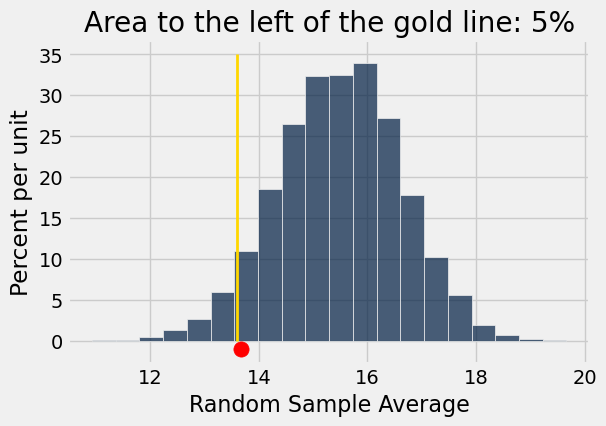

In [101]:
averages_tbl.hist(bins = 20)
plots.plot([five_percent_point, five_percent_point], [0, 0.35], color='gold', lw=2)
plots.title('Area to the left of the gold line: 5%');
plots.scatter(observed_average, -0.01, color='red', s=120);